## Explanation of Scoring Metric
I found the explanation for the scoring metric on this competition a little confusing, and I wanted to create a guide for those who are just entering or haven't made it too far yet.
Please leave me a comment if you found a mistake, thanks.

*This notebook is based on Stephen Bailey's [excellent explanation](https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric/notebook).*

------

The metric used for this competition is defined as **the mean average precision at different intersection over union (IoU) thresholds**.

These are the steps to calculate to correct score:

1. For all of the images/predictions
    * Calculate the Intersection of Union metric ("compare" the original mask with your predicted one)
    * Calculate whether your predicted mask fits at a range of IoU thresholds.
    * At each threshold, "calculate" the precision of your predicted masks.
    * Average the precision across thresholds.

2. Across the dataset
    * Calculate the mean of the average precision for each image.

### Picking test image
I'm going to pick a sample image from the training dataset, load the masks, then create a "mock predict"

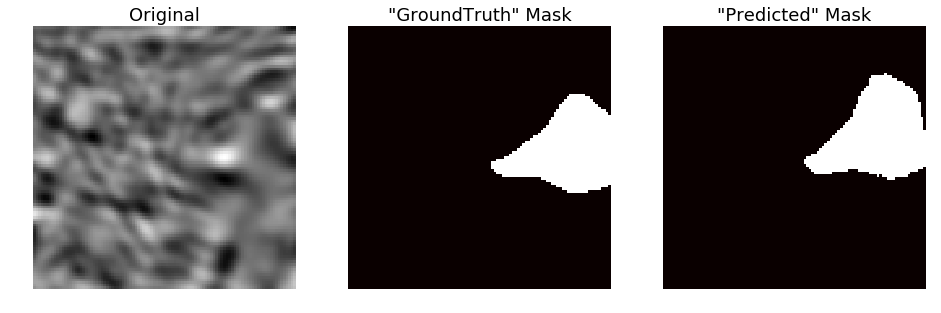

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio

from scipy import ndimage
from pathlib import Path

# Get image
im_id = '2bf5343f03'
im_dir = Path('data/salt/train/')
im_path = im_dir / 'images' / '{}.png'.format(im_id)
img = imageio.imread(im_path.as_posix())

# Get mask
im_dir = Path('data/salt/train/')
im_path = im_dir / 'masks' / '{}.png'.format(im_id)
target_mask = imageio.imread(im_path.as_posix())

# Fake prediction mask
pred_mask = ndimage.rotate(target_mask, 10, mode='constant', reshape=False, order=0)
pred_mask = ndimage.binary_dilation(pred_mask, iterations=1)

# Plot the objects
fig, axes = plt.subplots(1,3, figsize=(16,9))
axes[0].imshow(img)
axes[1].imshow(target_mask,cmap='hot')
axes[2].imshow(pred_mask, cmap='hot')

labels = ['Original', '"GroundTruth" Mask', '"Predicted" Mask']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)
    ax.axis('off')

### Intersection Over Union (for a single Prediction-GroundTruth comparison)
> The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
$$
IoU(A,B)=\frac{A∩B}{A∪B}
$$

The intersection and the union of our GT and Pred masks are look like this:

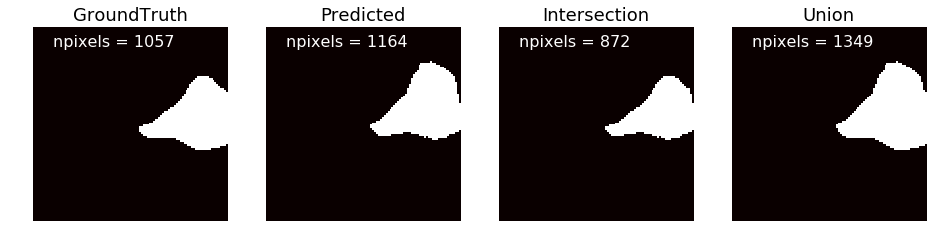

In [3]:
A = target_mask
B = pred_mask
intersection = np.logical_and(A, B)
union = np.logical_or(A, B)

fig, axes = plt.subplots(1,4, figsize=(16,9))
axes[0].imshow(A, cmap='hot')
axes[0].annotate('npixels = {}'.format(np.sum(A>0)), 
                 xy=(10, 10), color='white', fontsize=16)
axes[1].imshow(B, cmap='hot')
axes[1].annotate('npixels = {}'.format(np.sum(B>0)), 
                 xy=(10, 10), color='white', fontsize=16)

axes[2].imshow(intersection, cmap='hot')
axes[2].annotate('npixels = {}'.format(np.sum(intersection>0)), 
                 xy=(10, 10), color='white', fontsize=16)

axes[3].imshow(union, cmap='hot')
axes[3].annotate('npixels = {}'.format(np.sum(union>0)), 
                 xy=(10, 10), color='white', fontsize=16)

labels = ['GroundTruth', 'Predicted', 'Intersection', 'Union']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)
    ax.axis('off')

So, for this mask the **IoU** metric is calculated as:
$$
IoU(A,B)=\frac{A∩B}{A∪B} = \frac{872}{1349} = 0.6464
$$

### Thresholding the IoU value (for a single GroundTruth-Prediction comparison)
> Next, we sweep over a range of IoU thresholds to get a vector for each mask comparison. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (**0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95**).
In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

In [4]:
def get_iou_vector(A, B, n):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    s = pd.Series(name=n)
    for thresh in np.arange(0.5,1,0.05):
        s[thresh] = iou > thresh
    return s

print('Does this IoU hit at each threshold?')
print(get_iou_vector(A, B, 'GT-P'))

Does this IoU hit at each threshold?
0.50     True
0.55     True
0.60     True
0.65    False
0.70    False
0.75    False
0.80    False
0.85    False
0.90    False
0.95    False
Name: GT-P, dtype: bool


### Single-threshold precision for a single image

> At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects

I think this step causes the confusion.
I think the evaluation description of this competition was simply copied from the desc of the [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018#evaluation) (or something similar) competition, where you can predict more than one mask/object per image.

According to @William Cukierski's [Discussion thread](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/61550):
> Although this competition metric allows prediction of multiple segmented objects per image, note that we have encoded masks as one object here (see train.csv as an example). You will be best off to predict one mask per image.

Because of we have to predict only one mask per image, the computation below (from the evaluation desc) is a bit confusing:
>$$
Precision(t) = \frac{TP(t)}{TP(t)+FP(t)+FN(t)}
$$

This only makes sense if we would have more than one predicted mask/segment per image.
In our case I think this would be a better description:
* GT mask is empty, your prediction non-empty:  **(FP) Precision(threshold, image) = 0**
* GT mask non empty, your prediction empty: **(FN) Precision(threshold, image) = 0**
* GT mask empty, your prediction empty: **(TN) Precision(threshold, image) = 1**
* GT mask non-empty, your prediction non-empty: **(TP) Precision(threshold, image) = IoU(GT, pred) > threshold**
  
  
*See @William Cukierski's comment [here](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/61550#360922)*
> If a ground truth is empty and you predict nothing, you get a perfect score for that image. If the ground truth is empty and you predict anything, you get a 0 for that image.



### Multi-threshold precision for a single image
> The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:
$$
Avg. Precision = \frac{1}{n_{thresh}}  \sum_{t=1}^nprecision(t)
$$

Here, we simply take the average of the precision values at each threshold to get our mean precision for the image.

In [5]:
ppt = get_iou_vector(A, B, 'precisions_per_thresholds')
print ("Average precision value for image `{}` is {}".format(im_id, ppt.mean()))

Average precision value for image `2bf5343f03` is 0.3


Let's see what happens if our prediction is 100% accurate.

In [6]:
# `A` is the target mask
ppt = get_iou_vector(A, A, 'GT-P')
print('Does this IoU hit at each threshold?')
print(ppt)
print ("Average precision value for image `{}` is {}".format(im_id, ppt.mean()))

Does this IoU hit at each threshold?
0.50    True
0.55    True
0.60    True
0.65    True
0.70    True
0.75    True
0.80    True
0.85    True
0.90    True
0.95    True
Name: GT-P, dtype: bool
Average precision value for image `2bf5343f03` is 1.0


### Mean average precision for the dataset
>Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.

Therefore, the leaderboard metric will simply be the mean of the precisions across all the images.

**Please vote if you found this helpful or leave a comment if you found mistakes. **

**Thanks for reading.**